<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA

This notebook also calculates an average score (across the areas of the guest scores on various attributes such as cleanliness or service), and bucketize those scores into a binary sentiment (good = 1, bad = 0). The large data set is then sampled to a balanced sample of 5% of 444,233 reviews), and store that sample as a CSV.

In [24]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,Date,ReviewID
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,"April 20, 2012",UR128207934
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,"April 11, 2012",UR127662460
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,"April 11, 2012",UR127648467
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,"April 6, 2012",UR127365749
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...","April 2, 2012",UR127143142


In [27]:
df_reviews.shape

(444233, 11)

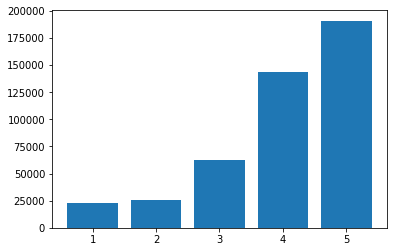

In [28]:
plt.bar([1, 2, 3, 4, 5], df_reviews['Overall'].value_counts().sort_index());

### Baseline using Overall column as targets. 

Accuracy just randomly guessing the class for an example

In [29]:
n_classes = df_reviews['Overall'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((n_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')

Baseline accuracy:  31.42%


In [30]:
# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)


In [31]:
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,average_score
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

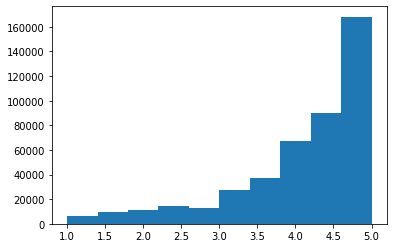

In [32]:
plt.hist(df_reviews['average_score'], bins=10);

### Approximate baseline accuracy

Guessing randomly of 10 classes accross distribution of average_scores

In [33]:
counts = np.histogram(df_reviews['average_score'], bins=10)[0]
n = df_reviews.shape[0]
baseline = np.sum((counts / n) ** 2)
print(f'Aporiximate baseline accuracy: {baseline * 100: .2f}%')

Aporiximate baseline accuracy:  22.13%


### Sample titles and descriptions by average score

In [34]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“Beware of Bed bugs!!” 
 Score =  1.00
We had found this serviced apartment in Abderdeen because most of the hotels were fully booked due to the time we had flown to Hong Kong. It
had cost us just over $ 300 CAD per night to stay here. At first, the place seemed pretty decent as there was ample space,a kitchen to make
breakfast, a tv, decent shower etc. Except when I woke up the next morning, i saw 14-15 red marks on my leg, which eventually grew in size
and was very itchy. It wasn't mosquitoe bites at all, and fit all the descriptions of bed bugs. This had thoroughly ruined my trip as my leg
was now scarred with these gross marks. I had to switch hotels and wash everything so i did not take these bugs back with me to Canada. Not
to mention, the front service desk person charged my credit card 4 times because he thought it didn't go through, whereas he had fed the
printer paper wrongly. I had to fix the printer paper for him which is absolutely ridiculous because i don

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

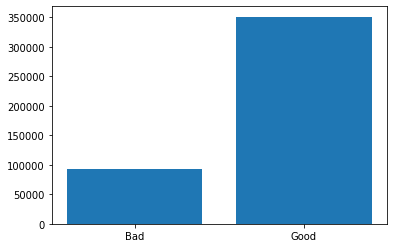

In [35]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

### Calculate a baseline accuracy

Randomly guessing 0 or 1 for each example

In [36]:
num_classes = df_reviews['sentiment'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((num_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')


Baseline accuracy:  66.89%


In [37]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Content,average_score,sentiment
166938,5,5,4,4,2,4,3,recommended business leisure stay rooms good s...,3.857143,1
427091,2,3,3,2,4,3,3,expected got room thru sale bookitcom luxury k...,2.857143,0
279945,4,4,4,4,4,4,3,stayed beforestayed againand would use family ...,3.857143,1
126963,5,5,5,4,5,5,4,smallest three secrets resorts intimate stayed...,4.714286,1
340692,5,5,5,5,5,5,5,impressive stayed hotel 1311217112 visited bar...,5.000000,1
325264,5,5,5,5,5,5,5,little gem stayed hotel 3 nights february fant...,5.000000,1
30882,4,5,3,4,2,4,3,great location top charges stayed dream 2 nigh...,3.571429,1
128722,4,5,5,4,5,4,4,great alterative downtown hotels glad find pub...,4.428571,1
39787,5,5,5,5,5,5,5,convenient midtown manhattan location located ...,5.000000,1
259555,5,4,4,5,5,5,3,first class hotel stayed 4 nights hotel staff ...,4.428571,1


### Make a CSV of a balanced sample

This way the baseline accuracy will be 50%

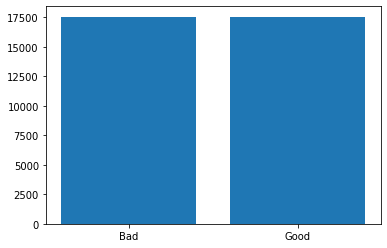

In [39]:
df1 = df_reviews[df_reviews['sentiment'] == 1].sample(frac=0.05)
rows = df1.shape[0]
df0 = df_reviews[df_reviews['sentiment'] == 0].sample(rows)
df_sampled = pd.concat([df0, df1], axis = 0)

df_sampled['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_sampled['sentiment'].value_counts().sort_index());

data_path = '/content/drive/MyDrive/hotel_reviews/reviews_sample.csv'
df_sampled.to_csv(data_path, index=False)
